# PFG Sell-out

Goal: 
1. Process PFG data (source = mealticket.com)
2. Analyze data using COVID segmentation
3. Compare sell-out (PFG) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [1]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import pyodbc

from distributor_transformation import transform_pfg, transform_pfg2, set_dictionary, set_time
from sellout_model import process_list, analyze, add_time
from sellout_teradata import teradata_sales
from sellout_import import import_pfg, all_df, import_all
from sellout_azure import azure_sellin

### Convert CSV To Pickle

In [2]:
import os
import pandas as pd

# Define the directory that contains your files
dir_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\PFG Refresh'

# Loop through all files in the directory
for filename in os.listdir(dir_path):
    # Check if the file is a csv
    if filename.endswith('.csv'):
        # Create the name of the pickle file
        pickle_filename = filename.replace('.csv', '.pkl')

        # Check if the pickle file already exists
        if pickle_filename not in os.listdir(dir_path):
            # If it doesn't exist, read the csv and create the pickle file
            df = pd.read_csv(os.path.join(dir_path, filename), low_memory=False, thousands=',', dtype={'Qty':'float64','Weight':'float64'})
            df.to_pickle(os.path.join(dir_path, pickle_filename))

### 3. Import File
Run cell below

In [3]:
%%time

df = import_pfg()

6026231
2024-04-15 00:00:00
CPU times: total: 2min 6s
Wall time: 2min 10s


In [4]:
#add dictionary to new data
df_pfg = transform_pfg(df, 'PFG - US.xlsx')

Starting dataframe shape: (6026231, 18)
These manufacturers were included: ['ANCHOR FROZEN FOODS INC', 'DOT FOODS (FROZEN)', 'ENDICO POTATOES INC.', 'MC CAIN FOODS INC', 'MCCAIN FOODS AFD', 'MCCAIN FOODS USA INC', 'MCCAIN FOODS USA INC-ACH', 'MCCAIN FOODS, INC. ', 'MCCAIN FOODSERVICE INC', 'MCCAIN PRODUCE INC', 'WH MOSELEY CO', 'MCCAIN FOODS', 'McCain Foods USA']
These manufacturers were not included:                   Manufacturer   count
2              SUPPLIER VARIES  142748
4          CAVENDISH FARMS INC   36301
5    JR SIMPLOT COMPANY FROZEN   14111
8             MCCAIN FOODS USA    3752
10         BIG DADDY FOODS INC    2612
12       LAMB WESTON SALES INC    1074
13        QUAKER BAKERY BRANDS    1045
14      MOORE FOOD SYSTEMS INC     981
17                 LAMB WESTON     847
20    ROSINA FOOD PRODUCTS INC     519
21               MOORE COLLINS     502
22                      MOORES     369
23        ROSINA FOOD PRODUCTS     178
24  PFG RESERVED PRODUCTS ONLY     148
25      MC

In [5]:
backup_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\Backups\\'

_base = all_df(df_pfg, backup_path, 'PFG.csv')

if 'Distributor' not in _base.columns:
    _base['Distributor'] = 'PFG'

Imported shape...(5816835, 30)
Final shape...(9520332, 13)


In [7]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

#Output 2: COVID L1 - List 1
_list.append(['State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','SKU ID','Consolidated Category','L1 Product Hierarchy','L2 Product Hierarchy'])

### 9. Execute Analysis
Run cell below

In [8]:
print(f'Processing Region', flush = True)

_base.loc[:, ['City','State','State Name']] = 'NA'
#_base.loc[:, ['City']] = 'NA'

#display(_base.head())
output1 = process_list(_base, _list[0], 'PFG')

Processing Region


In [9]:
print(f'Processing Sell in vs Sell out', flush = True)
output2 = azure_sellin(_base, 'US01', "','".join(['6500002801','6500002807']), 'PFG')

print('All done')                            

Processing Sell in vs Sell out
Query ran for 6500002801','6500002807 under sales org US01 for sales on or before 2024-04-21
All done, took 18.0 seconds...
All done


In [10]:
output1.to_csv('files/sellout_region_pfg.zip', compression='zip', index=False)
output2.to_csv('files/sellout_sellin_pfg.zip', compression='zip', index=False)

In [10]:
_base.to_csv(backup_path + 'PFG.csv')

In [22]:
output1.groupby('Week Ending (Sat)')['LBS'].sum()[-10:]

Week Ending (Sat)
2023-07-15    3898025.97
2023-07-22    4236981.29
2023-07-29    4159075.41
2023-08-05    4241359.96
2023-08-12    4221760.84
2023-08-19    4256780.73
2023-08-26    4204701.10
2023-09-02    4188428.81
2023-09-09    4130072.12
2023-09-16    4069698.41
Name: LBS, dtype: float64

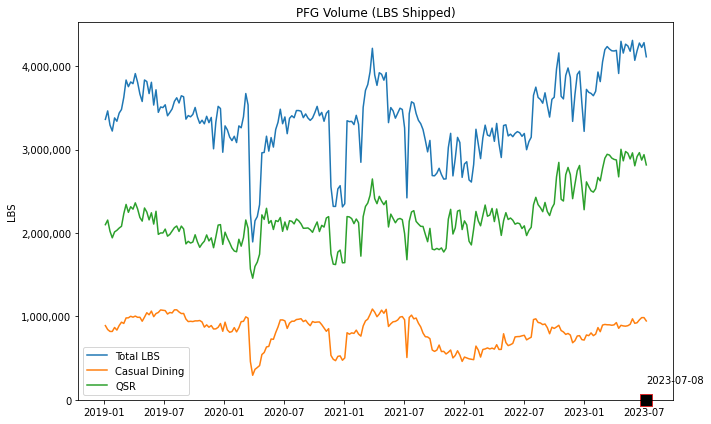

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)

fig, ax = plt.subplots()

graph_data = output1.groupby(['Week Ending (Sat)','COVID Segmentation - L1'])['LBS'].sum().reset_index()
#graph_data = _base.groupby(['Week Ending (Sat)','COVID Segmentation - L1'])['LBS'].sum().reset_index()

ax.plot('Week Ending (Sat)','LBS', data=graph_data.groupby('Week Ending (Sat)').sum().reset_index())
ax.plot('Week Ending (Sat)','LBS', data=graph_data[graph_data['COVID Segmentation - L1']=='Casual Dining'])
ax.plot('Week Ending (Sat)','LBS', data=graph_data[graph_data['COVID Segmentation - L1']=='QSR / Fast Casual'])

#creates timestamp of latest date
max_date = graph_data['Week Ending (Sat)'].max()
x = max_date
y = 0

plt.plot(x,y,'s', markerfacecolor='black', markersize=12, clip_on=False)

#matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)[source]

plt.text(x, 200000, max_date.date())

#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
ax.legend(['Total LBS', 'Casual Dining', 'QSR'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel('LBS')
ax.set_ylim(0)
ax.set_title(f'PFG Volume (LBS Shipped)')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

## PFG Export

In [10]:
import_test = pd.read_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\pfg_us_sellout.csv', parse_dates=['Invoice Week'])

In [11]:
import_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949678 entries, 0 to 4949677
Data columns (total 30 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Unnamed: 0        int64         
 1   Division          object        
 2   Sales Manager     object        
 3   Sales Rep Number  object        
 4   Sales Rep         object        
 5   Account Number    int64         
 6   Account Name      object        
 7   Address           object        
 8   City              object        
 9   State             object        
 10  Postal Code       object        
 11  Customer Class    object        
 12  Segment           object        
 13  Account Type      object        
 14  Vendor            object        
 15  Manufacturer      object        
 16  Brand             object        
 17  Brand Type        object        
 18  Product Category  object        
 19  Sub-Category      object        
 20  GTIN              float64       
 21  MFR SKU 

In [12]:
import_df = transform_pfg2(import_test, 'PFG - US.xlsx')

Starting dataframe shape: (4949678, 30)
Shape before adding dictionary: (4949678, 30)
Shape after adding dictionary: (5204637, 42)


In [13]:
import_df.head()

,Unnamed: 0,Division,Sales Manager,Sales Rep Number,Sales Rep,Account Number,Account Name,Address,City,State,...,COVID Segmentation - (Restaurants),COVID Segmentation - (Restaurants: Sub-Segment),Restaurant Service Type,Cuisine Type,Consolidated Category,L1 Product Hierarchy,L2 Product Hierarchy,Case Weight Lbs,Calendar Week Year,State Name
0,0,Maryland,"Harbolick, Peter",217,"Lutz, Sam",276602,CHAT N CHEW RESTAURANT,RR 220 25001 MCMULLEN HWY,MCCOOLE,MD,...,Restaurants,IO - Full Service,Sit Down,American Casual / Diner / Food Truck,Prepared Foods,Appetizer,Whole Cheese,2.0,202108,Maryland
1,1,Maryland,"Brockmeyer, Joe",352,"MCCORMACK, ELLEN",55050524,FUNTASTIC FOODS,2128 WHITEFORD RD,WHITEFORD,MD,...,Restaurants,IO - Full Service,Sit Down,Bar / Nightclubs / Sports Bar,Prepared Foods,Appetizer,Whole Cheese,2.0,202108,Maryland
2,2,Maryland,"Crawford, Dave",185,"Fetanis, Van",148432,AMPHORA CATERING,1151 ELDEN STREET,HERNDON,VA,...,Non-Restaurants,Non-Restaurants,Non-Restaurants,Non-Restaurants,Prepared Foods,Appetizer,Whole Cheese,12.0,202108,Virginia
3,3,Metro NY,"Julis, Mike",107,"Margolies, Lenny",253640,SEDONA TAPHOUSE,515 WEST AVENUE,NORWALK,CT,...,Restaurants,IO - Full Service,Sit Down,American Casual / Diner / Food Truck,Potato,Differentiated Fries,Clearcoat,30.0,202108,Connecticut
4,4,Metro NY,"Castiglione, Phil",117,"Lucchesi, Nicholas",229880,CROXLEY ALES-FRANKLIN SQR,129 NEW HYDE PARK RD,FRANKLIN SQ,NY,...,Restaurants,IO - Full Service,Sit Down,American Casual / Diner / Food Truck,Prepared Foods,Appetizer,Whole Vegetable,14.0,202108,New York


In [20]:
%%time
import_df.to_csv(r'files\pfg_sellout.zip', index=False, compression='zip')

CPU times: total: 2min 23s
Wall time: 2min 24s


In [16]:
import_df.columns

Index(['Unnamed: 0', 'Division', 'Sales Manager', 'Sales Rep Number',
       'Sales Rep', 'Account Number', 'Account Name', 'Address', 'City',
       'State', 'Postal Code', 'Customer Class', 'Segment', 'Account Type',
       'Vendor', 'Manufacturer', 'Brand', 'Brand Type', 'Product Category',
       'Sub-Category', 'GTIN', 'SKU ID', 'Dist SKU', 'Item Name', 'Pack',
       'Size', 'Unit Type', 'Qty', 'LBS', 'Invoice Week',
       'COVID Segmentation - L1', 'COVID Segmentation - L2',
       'COVID Segmentation - (Restaurants)',
       'COVID Segmentation - (Restaurants: Sub-Segment)',
       'Restaurant Service Type', 'Cuisine Type', 'Consolidated Category',
       'L1 Product Hierarchy', 'L2 Product Hierarchy', 'Case Weight Lbs',
       'Calendar Week Year', 'State Name'],
      dtype='object')

<AxesSubplot:xlabel='COVID Segmentation - L1'>

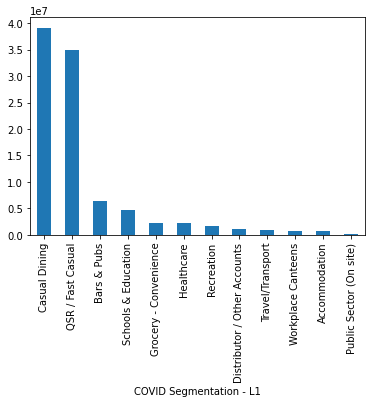

In [26]:
import_df.groupby('COVID Segmentation - L1', dropna=False)['Case Weight Lbs'].sum().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='COVID Segmentation - L2'>

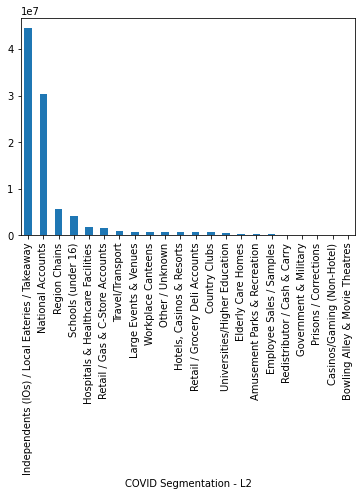

In [27]:
import_df.groupby('COVID Segmentation - L2', dropna=False)['Case Weight Lbs'].sum().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='Cuisine Type'>

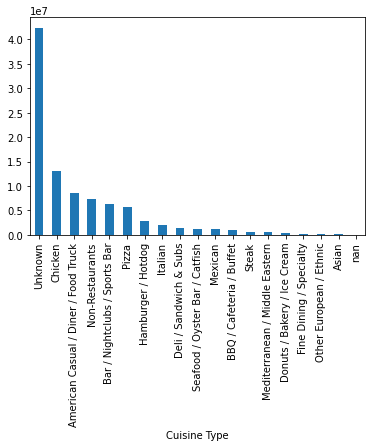

In [64]:
import_df.groupby('Cuisine Type', dropna=False)['Case Weight Lbs'].sum().sort_values(ascending=False).plot(kind='bar')

In [32]:
import_df['COVID Segmentation - L2'].value_counts()

COVID Segmentation - L2
Independents (IOs) / Local Eateries / Takeaway    2754828
National Accounts                                 1389277
Region Chains                                      311961
Schools (under 16)                                 169094
Retail / Gas & C-Store Accounts                    104818
Hospitals & Healthcare Facilities                   83390
Travel/Transport                                    60968
Large Events & Venues                               48841
Other / Unknown                                     47241
Retail / Grocery Deli Accounts                      38757
Country Clubs                                       37995
Workplace Canteens                                  37446
Hotels, Casinos & Resorts                           34803
Universities/Higher Education                       25698
Elderly Care Homes                                  15694
Amusement Parks & Recreation                        11181
Employee Sales / Samples                        

In [50]:
groupby_columns = ['COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Cuisine Type']

group1 = import_df.groupby(groupby_columns)['Case Weight Lbs'].sum().reset_index()

In [52]:
group1.to_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\Junk\pfg_segmentation_test.csv', index=False)

In [46]:
mask = (import_df['COVID Segmentation - L1'] == 'Casual Dining') & \
    (import_df['COVID Segmentation - L2'] == 'Independents (IOs) / Local Eateries / Takeaway') & \
    (import_df['Restaurant Service Type'] == 'Sit Down')

group1 = import_df[mask].groupby(['Account Name','Cuisine Type'], dropna=False)['Case Weight Lbs'].sum().reset_index()

In [49]:
group1.groupby('Cuisine Type')['Case Weight Lbs'].sum().sort_values(ascending=False)

Cuisine Type
Unknown                                 1.662281e+07
American Casual / Diner / Food Truck    7.762075e+06
Pizza                                   3.551750e+06
Italian                                 1.369021e+06
Seafood / Oyster Bar / Catfish          1.238934e+06
Mexican                                 1.027074e+06
BBQ / Cafeteria / Buffet                8.564551e+05
Mediterranean / Middle Eastern          4.750880e+05
Steak                                   4.319249e+05
Fine Dining / Specialty                 2.252001e+05
Other European / Ethnic                 1.869325e+05
Asian                                   1.316895e+05
Name: Case Weight Lbs, dtype: float64

In [61]:
import_df[import_df['Cuisine Type'] == 'Unknown'][['Customer Class','Segment','Account Type']].head(15)

,Customer Class,Segment,Account Type
58,INDEPENDENT CUSTOMER,QSR,PURE STREET
72,INDEPENDENT CUSTOMER,Restaurants,INDEPENDENT CUSTOMER
88,INDEPENDENT CUSTOMER,Restaurants,INDEPENDENT CUSTOMER
89,INDEPENDENT CUSTOMER,MSD-Other,INDEPENDENT CUSTOMER
90,NATIONAL CUSTOMER,FAST FOODS,NATIONAL CUSTOMER
91,NATIONAL CUSTOMER,FAST FOODS,NATIONAL CUSTOMER
172,REGIONAL CUSTOMER,Casual,PROGRAM STREET
177,NATIONAL CUSTOMER,FAST FOODS,NATIONAL CUSTOMER
197,NATIONAL CUSTOMER,FAST FOODS,NATIONAL CUSTOMER
198,NATIONAL CUSTOMER,FAST FOODS,NATIONAL CUSTOMER


In [59]:
import_df['Account Name'].describe()

count     5204637
unique      86163
top       ZAXBY'S
freq         3036
Name: Account Name, dtype: object

In [63]:
import_df[import_df['Cuisine Type'] == 'Unknown'].groupby(['Account Name','Customer Class','Segment','Account Type']).size().reset_index()

Account Name               Customer Class        Segment                  Account Type
#01 EL TORO OF LIMESTONE   Independent Customer  Unassigned               Street            2
#02 EL TORO BELLBROOK      Independent Customer  Unassigned               Street            1
#04 EL TORO Vandalia       Independent Customer  Unassigned               Street            1
#05 EL TOROOLD Huber Hts.  Independent Customer  Unassigned               Street            2
#06 EL TORO BECHTLE        Independent Customer  Unassigned               Street            3
                                                                                         ... 
ssm-azalea estates slidel  Regional Customer     HOSPITAL/NURSING HOMES   Healthcare       48
tROUBLE'S II               Independent Customer  RESTAURANT-FULL SERVICE  Street          178
tavern on the green        Independent Customer  RESTAURANT-FULL SERVICE  Street           27
teds                       Independent Customer  Unassigned        

# PFG - SQL Server

In [1]:
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.engine import URL
from datetime import datetime, timedelta
import pandas as pd
import os
import regex as re

class pfg_sellout:
    def __init__(self, file_path) -> None:
        self.filepath = file_path
        self.dates = self.extract_dates_from_filename()
        self.data = self.process_file()
        self.data_import = self.filter_rows()
        #self.delete_rows()
        self.insert_rows()

    def extract_dates_from_filename(self):
        # Extracting the filename from the path
        file_name = os.path.basename(self.filepath)

        # Define the regular expression pattern for dates
        date_pattern = r'\d{4}-\d{2}-\d{2}'

        # Find all occurrences of the pattern
        dates = re.findall(date_pattern, file_name)

        # Convert strings to datetime objects
        dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

        return dates

    def process_file(self):
        df = pd.read_csv(self.filepath, low_memory = False, thousands = ',')

        rename_columns = {
            'MFR SKU':'McCain SKU ID',
            'GTIN':'Manufacturer GTIN',
            'MFG Number':'McCain SKU ID'
        }

        # Rename columns
        df.rename(columns=rename_columns, inplace=True)

        df['Manufacturer GTIN'] = df['Manufacturer GTIN'].astype(str)
        df['Account Number'] = df['Account Number'].astype(int).astype(str)

        # Add week beginning column
        # Assuming beginning date is on Monday
        df['Week Beginning Date'] = pd.to_datetime(self.dates[0] - timedelta(days=1))

        # Upper case everything in columns
        columns_to_edit = [
            'Account Name','Address','City','State'
        ]

        for col in columns_to_edit:
            df[col] = df[col].str.upper()
        
        columns_to_edit = [
            'Division','Account Number','Account Name','Address','City','State','Postal Code',
            'Customer Class','Segment','Account Type','Vendor','Manufacturer'
        ]

        for col in columns_to_edit:
            df[col] = df[col].str.strip()

        columns_to_keep = [
            'Division','Account Number','Account Name','Address','City','State','Postal Code',
            'Customer Class','Segment','Account Type','Vendor','Manufacturer',
            'Manufacturer GTIN','McCain SKU ID','Dist SKU','Item Name','Pack','Size','Unit Type',
            'Qty','Weight','Week Beginning Date'
        ]
        
        if df['Pack'].dtypes == 'object':
            # Use the str.split method on the entire 'Pack' column to split by '/'
            # The expand=True parameter will split the 'Pack' column into two new columns
            split_df = df['Pack'].str.split('/', n=1, expand=True)

            # Assign the first part of the split to 'Pack' only if there was a split (i.e., a '/')
            df['Pack'] = split_df[0].where(split_df[1].notna(), df['Pack'])

            # The second part of the split, along with the unit if it exists, to 'Size'
            # but only if there was something after the '/' (notna())
            df['Size'] = split_df[1].where(split_df[1].notna(), df['Size'])

        return df[columns_to_keep]
    
    def setup_connection():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = (
            f'DRIVER={driver};'
            f'SERVER=tcp:{server};'
            f'DATABASE={database};'
            'Authentication=ActiveDirectoryIntegrated'
        )

        cnxn = pyodbc.connect(conn_str)
        cursor = cnxn.cursor()

        return cnxn, cursor


    def filter_rows(self):
        sql_select = """
        SELECT [Week Beginning Date] 
        FROM [na_dist].[US_PFG_Sellout]
        GROUP BY [Week Beginning Date] """

        cnxn, cursor = pfg_sellout.setup_connection()

        cursor.execute(sql_select)

        # Fetch the results
        results = cursor.fetchall()

        # Convert the results into a list of dates
        dates_in_db = [result[0] if result[0] is not None else None for result in results]
        dates_in_db = pd.to_datetime([date for date in dates_in_db if date is not None])

        # Commit the transactions
        cnxn.commit()

        # Close the connection
        cursor.close()
        cnxn.close()

        return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]

    def setup_miengine():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = URL.create(
            'mssql+pyodbc',
            query={
                'odbc_connect':(
                    f'DRIVER={driver};'
                    f'SERVER=tcp:{server};'
                    f'DATABASE={database};'
                    'Authentication=ActiveDirectoryIntegrated;'
            )
            }
        )

        engine = create_engine(conn_str, connect_args={"autocommit": True}, fast_executemany=True, use_insertmanyvalues=False)

        return engine

        
    def insert_rows(self):
        engine = pfg_sellout.setup_miengine()

        table_name = 'US_PFG_Sellout'
        schema_name = 'na_dist'

        # If the table doesn't exist, it will be created automatically
        self.data_import.to_sql(table_name, con=engine, schema=schema_name, if_exists='append', index=False)

In [2]:
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-05-10\Sales_Report_Builder_(2024-04-29 - 2024-05-05).csv'

pfg_sellout(file_path)


In [43]:
import os

# The path to the directory containing the folders
directory_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files'

cnt = 0

# Loop through each folder and file in the directory
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if "SharedTable_weekly_cases" is in the filename
        if ("Meal Ticket" in file and file.endswith('.csv') and "2021" in file) or ("Sales_Report_Builder" in file and file.endswith('.csv') and "2024" in file):
            #cnt += 1
            # Construct the full file path
            file_path = os.path.join(root, file)
            
            print(file_path)

            pfg_sellout(file_path)

            #if cnt >= 30:
            #   break

C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-09\Data Sources\Meal Ticket - Sales Report - (2021-03-29 - 2021-04-04).csv
C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-16\Data Sources\Meal Ticket - Sales Report - (2021-04-05 - 2021-04-11).csv
C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-23\Data Sources\Meal Ticket - Sales Report - (2021-04-12 - 2021-04-18).csv
C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-30\Data Sources\Meal Ticket - Sales Report - (2021-04-19 - 2021-04-25).csv
C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-05-05\Data Sources\Meal Ticket - Sales Report - (2021-04-26 - 2021-05-02).csv
C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-05-14\Data Sources\Meal Ticket - S

In [5]:
def extract_dates_from_filename(filename):
    # Define the regular expression pattern for dates
    date_pattern = r'\d{4}-\d{2}-\d{2}'

    # Find all occurrences of the pattern
    dates = re.findall(date_pattern, filename)

    # Convert strings to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    return dates

# Example usage
filename = "Meal Ticket - Sales Report - (2024-03-18 - 2024-03-24).csv"
dates = extract_dates_from_filename(filename)

dates[1]

datetime.datetime(2024, 3, 24, 0, 0)